In [1]:
# Imports
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os, sys

# Add directory to path
dir_name = os.path.dirname(os.getcwd())
sys.path.insert(1, dir_name)

# Import qlab's analysis sub-module
from qlab import analysis as qla

# Load dot env file
load_dotenv(dotenv_path=dir_name+'/qlab/.env')

# Connect to Heroku PostgreSQL
db = qla.HerokuDB(os.environ.get("HERO_URI"))
db.connect()

# Print DB tables
db.print_tables()

Connected to DB, cursor is created
Table:  ishares --- rows: 13
Table:  exchanges --- rows: 109
Table:  ft_exchanges --- rows: 7
Table:  securities --- rows: 91
Table:  etfs_data --- rows: 90
Table:  transactions --- rows: 39
Table:  prices --- rows: 89
Table:  market_segments --- rows: 89


In [2]:
pr = db.prices_table_read(assets_list=['SWDA','EIMI','EXXT','IUSA','SPYY'],portfolio=False)


In [147]:
def simpleCrossOver(asset, quick, slow, exponential=False):
    '''
    
    '''
    
    if exponential:
        # Exponential moving average
        a =  asset.ewm(span=quick, min_periods=quick, adjust=False).mean()
        b =  asset.ewm(span=slow, min_periods=slow, adjust=False).mean()
    
    else:
        # Simple moving average
        a = asset.rolling(quick).mean()
        b = asset.rolling(slow).mean()
    
    # Price crossover differential - shifted 1 period forward
    price_cross =((a-b)/asset).shift(1).dropna()
        
    return price_cross


def priceCrossOverSignal(asset, quick, slow, threshold=0, diff_per=5, adj_per=5, exponential=False):
    '''
    
    '''
    
    if exponential:
        # Exponential moving average
        a =  asset.ewm(span=quick, min_periods=quick, adjust=False).mean()
        b =  asset.ewm(span=slow, min_periods=slow, adjust=False).mean()
    
    else:
        # Simple moving average
        a = asset.rolling(quick).mean()
        b = asset.rolling(slow).mean()
    
    # Price crossover differential - shifted 1 period forward
    price_cross =(a-b).diff(diff_per).shift(1).dropna()
    
    # Rolling mean price
    asset_adjustment = asset.rolling(window=adj_per, min_periods=adj_per).mean().shift(1).dropna()
    
    # Calculate signal
    # Have exposure if the price differential over the last N periods > a fraction of the asset's price
    # where price = mean price over the last M periods
    signal = ( price_cross > threshold * asset_adjustment.loc[price_cross.index] ) + 0
    signal[0] = 0
        
    return signal

def calculateHoldingPeriod(signal):
    per = 0
    periods = []
    for i in signal:
        if i == 0 :
            if per>0:
                # print('New period length: ', per)
                periods.append(per)
            per = 0
        else:
            per += 1
    
    if len(periods)>0:
        return pd.DataFrame(periods).describe()
    else:
        return pd.DataFrame(data=[0,0],columns=['0'],index=['mean','50%'])
    
def runBacktest(signal, asset):

    x = pd.concat([asset, signal],axis=1).dropna()
    x.columns = ['Asset','Signal']
    
    bt = qla.BackTest()
    
    return bt.evaluate_strategy(prices_df = x[['Asset']], signals_df = x[['Signal']], original_weights=[1])


def create_strat(asset, quick, slow, threshold):
    
    signals_data = pd.DataFrame(index=asset.index)

    strat_data = pd.DataFrame(index=asset.index)

    summary = pd.DataFrame(columns=['Net', 'Value', 'BH', 'Fees', 'Mean HPR', 'Median HPR', 'Exposure'])


    for q in quick:
        for l in slow:
            comb = str(q) + ' - ' + str(l)
            
            s = priceCrossOverSignal(asset, q, l, threshold)
            r = runBacktest(s, asset)
            
            signals_data[comb] = s
            hpr = calculateHoldingPeriod(s)
            
            strat_data[comb] = r['VALUE']

            summary.loc[comb,'Value'] = r['VALUE'].iloc[-1]
            summary.loc[comb,'BH'] = r['BUY_HOLD'].iloc[-1]
            summary.loc[comb,'Fees'] = r['TOTAL_FEES'].sum()
            summary.loc[comb,'Net'] = (r['VALUE']-r['BUY_HOLD']).iloc[-1]-r.TOTAL_FEES.sum()
            
            summary.loc[comb,'Mean HPR'] = hpr.loc['mean'][0].round(1)
            summary.loc[comb,'Median HPR'] = hpr.loc['50%'][0].round(1)
            summary.loc[comb,'Exposure'] = r.SIG_Signal.sum()/len(r.SIG_Signal.dropna())
            
            print(comb, ' done')

    strat_data['BH'] = asset.copy()
    
    return strat_data, summary, signals_data

In [8]:
def plotStrategy(signal, asset, asset2=None):
    if asset2 is None:
        vis=pd.concat([signal.dropna(), asset.dropna()],axis=1)
    else:
        vis=pd.concat([signal.dropna(), asset.dropna(), asset2.dropna()],axis=1)
    vis.iloc[:,0].plot(figsize=(15,8),kind='area')
    vis.iloc[:,1].plot(secondary_y=True)
    if asset2 is not None:
        vis.iloc[:,2].plot(secondary_y=True)

### EXXT

8 - 21  done
8 - 65  done
8 - 130  done
8 - 160  done
12 - 21  done
12 - 65  done
12 - 130  done
12 - 160  done
16 - 21  done
16 - 65  done
16 - 130  done
16 - 160  done
20 - 21  done
20 - 65  done
20 - 130  done
20 - 160  done


,Net,Value,BH,Fees,Mean HPR,Median HPR,Exposure
12 - 21,8507.51913,106401.76,97718.235,176.00587,1132.0,536.0,0.995728
20 - 65,7685.5929,91402.21,83352.195,364.4221,1270.7,467.0,0.990597
20 - 130,6715.67499,89440.45,82322.74,402.03501,746.4,465.0,0.986305
8 - 21,3321.859148,102538.724,97718.235,1498.629852,183.9,128.0,0.978387
12 - 65,1289.232252,85889.3585,83352.195,1247.931249,206.6,97.5,0.967217
16 - 21,653.34499,98403.79,97718.235,32.21001,540.0,540.0,0.999497
16 - 65,568.946613,84654.317,83352.195,733.175387,342.8,125.0,0.980178
20 - 21,-12.196905,97718.235,97718.235,12.196905,0,0,1.0
16 - 130,-384.249334,82812.668,82322.74,874.177334,263.5,168.5,0.975452
12 - 130,-2479.127866,81280.0455,82322.74,1436.433367,182.2,129.0,0.963824


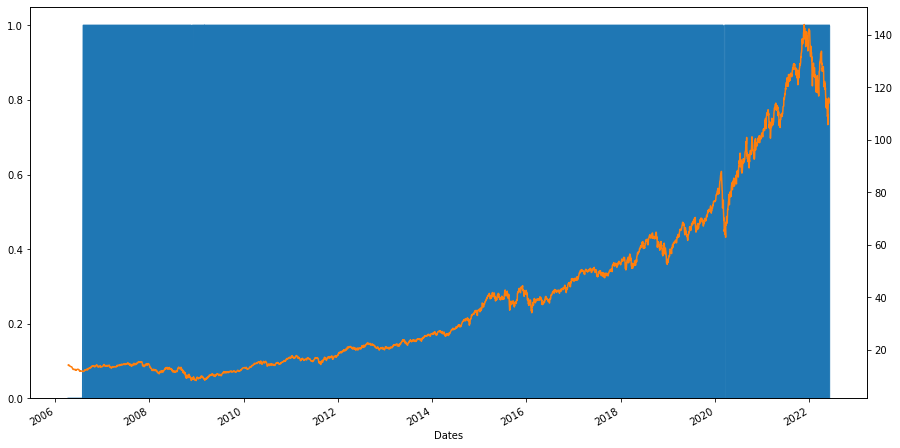

In [837]:

exxt_strat, exxt_summary, exxt_signals = create_strat(pr.EXXT, quick=[8, 12, 16, 20],
                                                        slow=[21, 65, 130, 160],
                                                        threshold=-0.03)


summ = exxt_summary.sort_values(by='Net',ascending=False)

display(summ)

plotStrategy(exxt_signals[summ.index[0]], pr.EXXT)

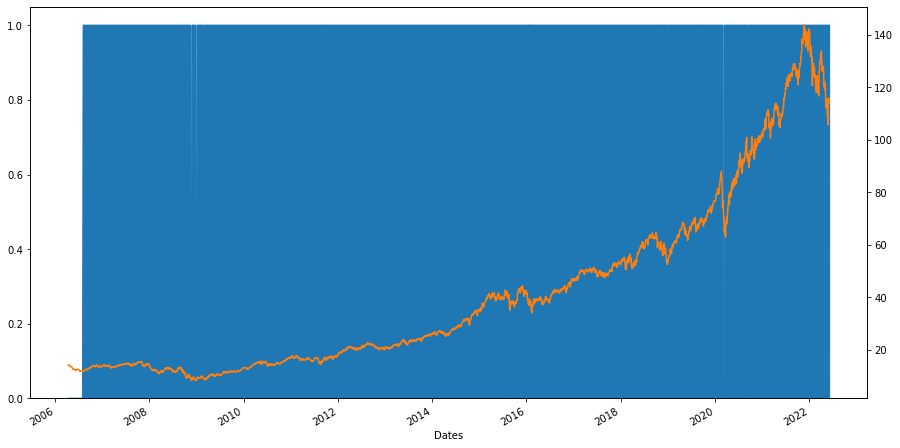

In [844]:
plotStrategy(exxt_signals[summ.index[3]], pr.EXXT)

In [122]:
# qla.plot_line(exxt_strat[list(summ.index[:4])+['BH']].dropna(), rebase=True)

### Cumulative returns as trend following signal

In [3]:
def getCumReturns(asset, lags):
    
    ret = pd.DataFrame(index=asset.index)
    for i in lags:
       
        ret[i] = asset.pct_change(i)
    
    # Exponential weights
    w = pd.DataFrame(len(lags)/pd.DataFrame([i for i in range(1,len(lags)+1)]).ewm(com=0.5).mean())
    w.index = lags
    w = w/w.sum()

    ret['Overall'] = ret.mul(w.T.values).sum(axis=1)
    return ret.dropna(), w


<AxesSubplot:xlabel='Dates'>

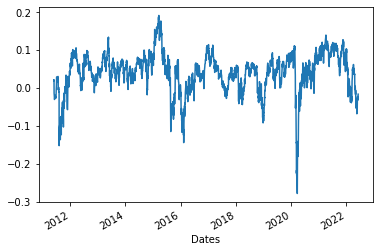

In [4]:
rr, w = getCumReturns(pr.SWDA,[21,21*2,21*3,21*4,21*5,21*6,21*7,21*8,21*9,21*10,21*11,21*12])
rr.Overall.plot()



<AxesSubplot:xlabel='Dates'>

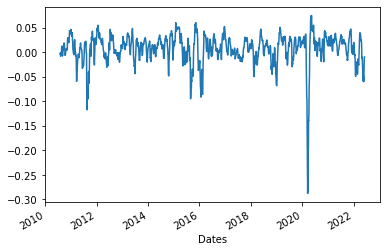

In [148]:
simpleCrossOver(pr.SWDA,5,40).plot()

In [172]:
# sig = ( (rr.Overall>0) | ((rr.Overall<0) & ( (rr.Overall.diff(10)>0)) ) )
# sig = ( (rr.Overall>0) | (rr.Overall.diff(10)>0) | (rr.Overall.diff(5)>0) )
# sig = (rr.Overall>0) | ( (rr.Overall < 0) & ((rr.Overall.diff(5) > 0)|(rr.Overall.diff(10) > 0)) )
# sig = (rr.Overall>-0.05) & (simpleCrossOver(pr.SWDA.dropna(),5,40)>-0.05)
sig = (rr.Overall>0) | (simpleCrossOver(pr.SWDA.dropna(),10,150).diff(10)>0)

sig = (sig+0).shift(1).dropna()
sig[0]=0
sig.value_counts()



1.0    2460
0.0     448
dtype: int64

In [173]:
br = runBacktest(sig,pr.SWDA)
br



,Asset,SIG_Signal,CNT,TRP_Asset,UNT_Asset,NET_PURCHASES,CASH,VALUE,BUY_HOLD,PCT_FEES,FLAT_FEES,TOTAL_FEES
2011-05-30,NaN,NaN,NaN,NaN,0.0,0.000,10000.000,10000.000,10000.000,0.000000,0.0,0.000000
2011-05-31,21.210,1.0,1.0,21.2050,471.0,9987.555,12.445,10002.355,10002.355,9.987555,2.2,12.187555
2011-06-01,21.200,1.0,1.0,21.2050,471.0,0.000,12.445,9997.645,9997.645,0.000000,0.0,0.000000
2011-06-02,21.200,1.0,1.0,21.2000,471.0,0.000,12.445,9997.645,9997.645,0.000000,0.0,0.000000
2011-06-03,20.435,1.0,1.0,20.8175,471.0,0.000,12.445,9637.330,9637.330,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31,72.500,0.0,0.0,72.8350,0.0,0.000,23319.645,23319.645,34159.945,0.000000,0.0,0.000000
2022-06-01,72.430,0.0,0.0,72.4650,0.0,0.000,23319.645,23319.645,34126.975,0.000000,0.0,0.000000
2022-06-02,72.570,0.0,0.0,72.5000,0.0,0.000,23319.645,23319.645,34192.915,0.000000,0.0,0.000000
2022-06-03,72.320,0.0,0.0,72.4450,0.0,0.000,23319.645,23319.645,34075.165,0.000000,0.0,0.000000


In [174]:
br.SIG_Signal.sum()/len(br.SIG_Signal)

0.8763804773779836

In [175]:
br.TOTAL_FEES.sum()

1826.608445

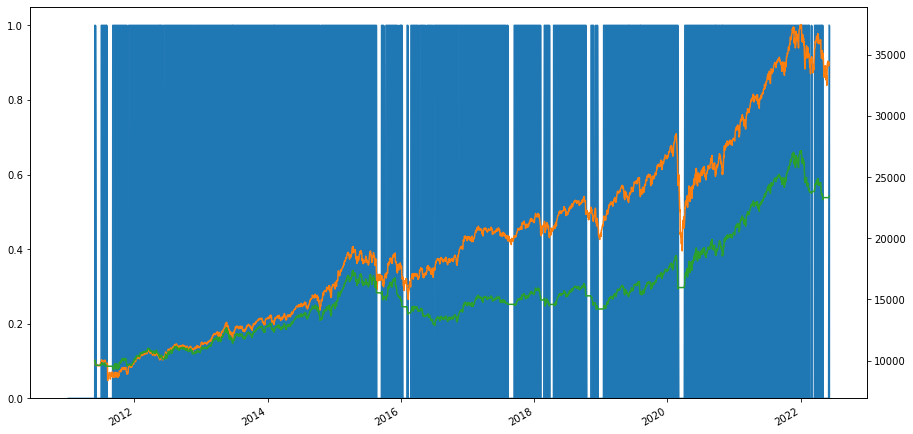

In [176]:
plotStrategy( sig,br.BUY_HOLD,br.VALUE)

